<a href="https://colab.research.google.com/github/dana-naderi/dana-naderi.github.io/blob/master/21_feb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
install.packages("mvtnorm")
install.packages("dplyr")
library(mvtnorm)
library(dplyr)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [ ]:
set.seed(123)
s0 <- 1
n <- 20
d <- 2
mu_star <- rep(1, d)
mcmc_itr <- 4000

Y <- rmvnorm(n, mu_star, sigma = diag(d))
sn <- 1 / (n + 1/s0)
#mn <- colMeans(Y) * n / (n + 1/s0)
mn = apply(Y,2,sum)/(n + 1/s0)

sample_posterior <- rmvnorm(mcmc_itr, mn, sigma = sn * diag(d))
sample_ball <- sample_posterior[1:(mcmc_itr/4),]
sample_cov <- sample_posterior[(mcmc_itr/4+1):(mcmc_itr/2),]
sample_est <- sample_posterior[(mcmc_itr/2+1):mcmc_itr,]


In [ ]:

# Function to process samples using log-densities
process_sample_log <- function(mu_sample) {
  # Compute log-prior density
  log_prior_density <- dmvnorm(mu_sample, mean = rep(0, d), sigma = s0 * diag(d), log = TRUE)

  # Compute log-likelihood for each theta
  log_likelihood <- apply(mu_sample, 1, function(theta) {
    sum(dmvnorm(Y, mean = theta, sigma = diag(d), log = TRUE))
  })

  # Compute log-posterior density (log-prior + log-likelihood)
  log_posterior_densities <- log_prior_density + log_likelihood

  # Return a data frame with log-densities
  data.frame(
    theta1 = mu_sample[, 1],
    theta2 = mu_sample[, 2],
    log_density = log_posterior_densities
  ) %>% arrange(desc(log_density))
}

# Process samples using log-densities
posterior_samples_ball <- process_sample_log(sample_ball)
HPD_samples_ball <- head(posterior_samples_ball, mcmc_itr / 8)
Non_HPD_sample_ball <- tail(posterior_samples_ball, mcmc_itr / 8)

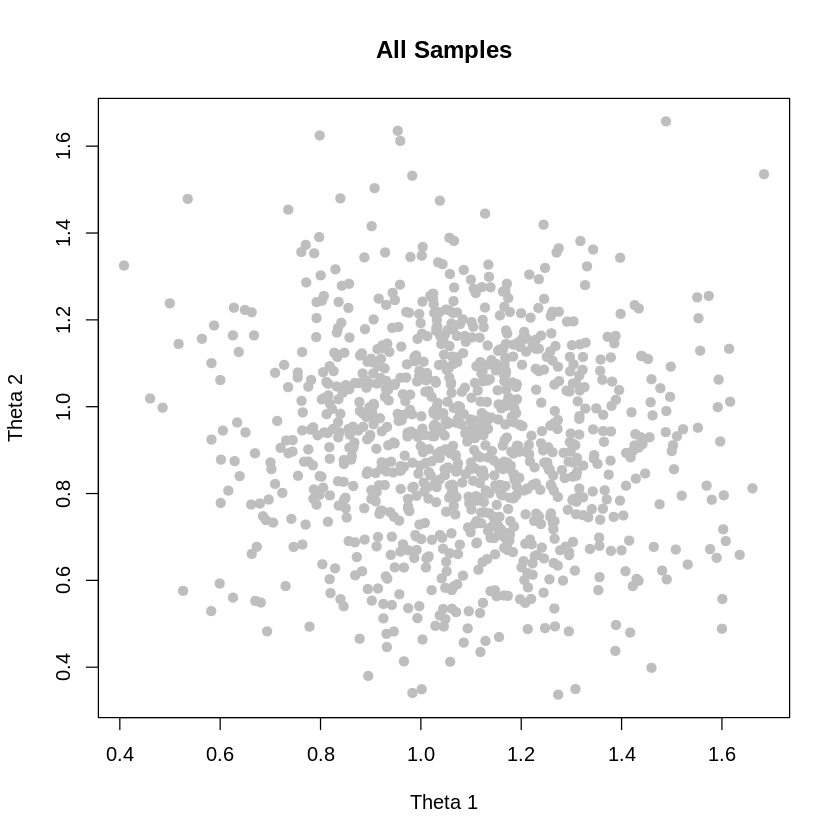

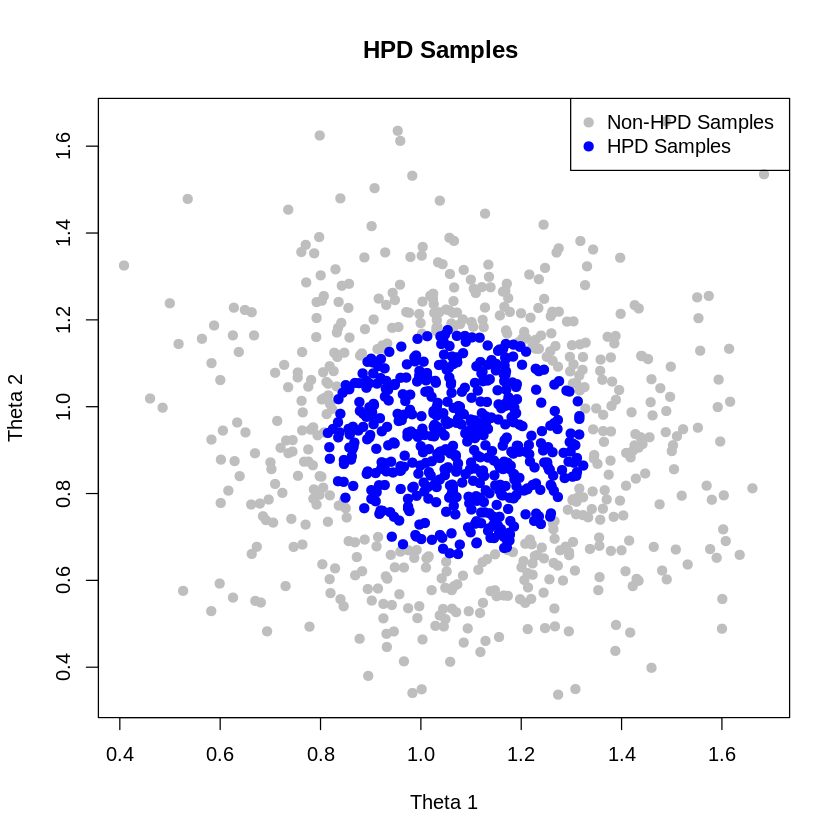

In [ ]:
plot(posterior_samples_ball$theta1, posterior_samples_ball$theta2, col = "grey", pch = 19,
     xlab = "Theta 1", ylab = "Theta 2", main = "All Samples")

plot(posterior_samples_ball$theta1, posterior_samples_ball$theta2, col = "grey", pch = 19,
     xlab = "Theta 1", ylab = "Theta 2", main = "HPD Samples ")
points(HPD_samples_ball$theta1, HPD_samples_ball$theta2, col = "blue", pch = 19)
legend("topright", legend = c("Non-HPD Samples", "HPD Samples"),
       col = c("grey", "blue"), pch = 19)


In [ ]:
exact_log_marginal <- - n*d*log(2*pi)/2 - d*log(s0*n+1)/2 - sum(Y^2)/2 + sum(colSums(Y)^2)/(2*(n+1/s0))

In [ ]:
# Compute log-terms instead of raw terms
log_term1 <- (- (d * n) / 2) * log(2 * pi)  # log( (2 * pi)^(- (d * n) / 2) )
log_term2 <- (- d / 2) * log(1 + s0 * n)    # log( (1 + s0 * n)^(- d / 2) )

# Compute sum of squares and other terms
sum_yij2 <- sum(Y^2)
sum_yij <- colSums(Y)
sum_yij_sq <- sum(sum_yij^2)

# Compute the exponent term in log-space
log_exponent_term <- -0.5 * (sum_yij2 - (s0 / (1 + s0 * n)) * sum_yij_sq)

# Combine all terms to get the log marginal likelihood
log_exact_marginal_likelihood <- log_term1 + log_term2 + log_exponent_term

# Print results
cat("Exact Log Marginal Likelihood:", log_exact_marginal_likelihood, "\n")
cat("Exact Marginal Likelihood:", exp(log_exact_marginal_likelihood), "\n")


Exact Log Marginal Likelihood: -56.43202 
Exact Marginal Likelihood: 3.103741e-25 


In [ ]:
# Find the first center (point with the highest density in HPD samples)
first_center <- HPD_samples_ball[which.max(HPD_samples_ball$log_density), ]
# Function to find the maximum radius for a ball centered at `center`
find_max_radius <- function(center, non_hpd_samples) {
  # Compute Euclidean distances between the center and non-HPD samples
  non_hpd_distances <- sqrt((non_hpd_samples$theta1 - center$theta1)^2 +
                            (non_hpd_samples$theta2 - center$theta2)^2)

  # Find the minimum distance (maximum radius before including non-HPD samples)
  max_radius <- min(non_hpd_distances, na.rm = TRUE)

  return(max_radius)
}
# Compute the maximum radius for the first center
max_radius <- find_max_radius(first_center, Non_HPD_sample_ball)


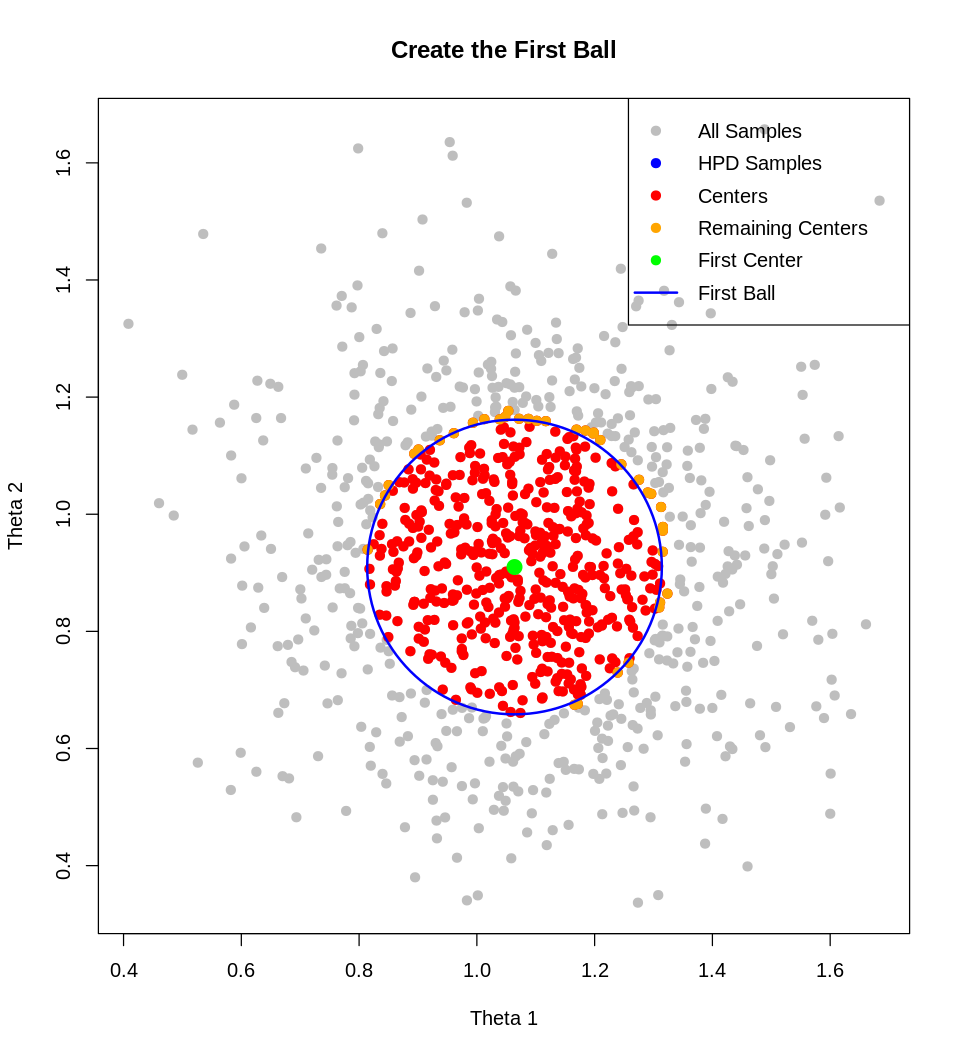

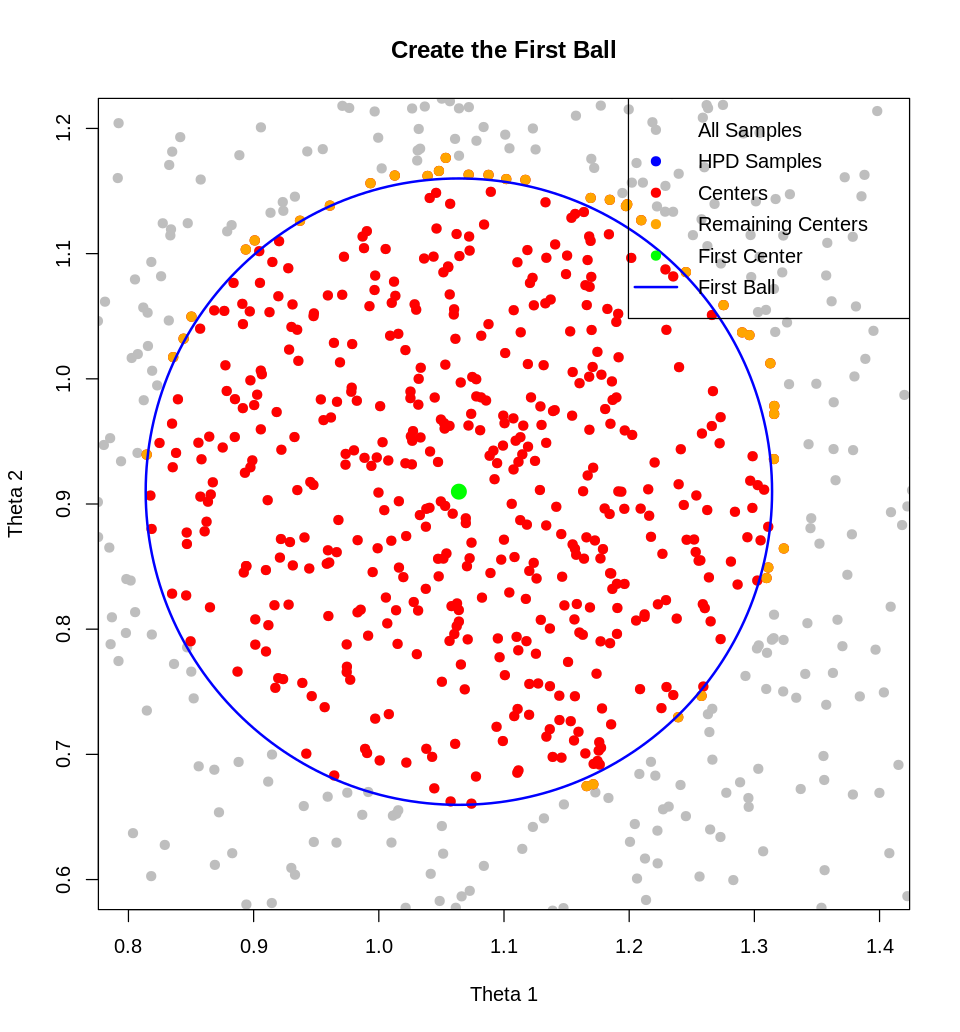

In [ ]:



# Add distance from the first center to all HPD samples
HPD_samples_ball$distance <- sqrt((HPD_samples_ball$theta1 - first_center$theta1)^2 +
                                 (HPD_samples_ball$theta2 - first_center$theta2)^2)

# Filter remaining centers (points outside the first ball)
remaining_centers <- HPD_samples_ball %>% filter(distance > max_radius)

# Plot all samples and the first ball
options(repr.plot.width = 8, repr.plot.height = 8.8)
plot(posterior_samples_ball$theta1, posterior_samples_ball$theta2, col = "grey", pch = 19,
     xlab = "Theta 1", ylab = "Theta 2", main = "Create the First Ball")
points(HPD_samples_ball$theta1, HPD_samples_ball$theta2, col = "red", pch = 19)
points(remaining_centers$theta1, remaining_centers$theta2, col = "orange", pch = 19)
points(first_center$theta1, first_center$theta2, col = "green", pch = 19, cex = 1.5, lwd = 2)

# Draw the first ball
symbols(first_center$theta1, first_center$theta2, circles = max_radius,
        inches = FALSE, add = TRUE, fg = "blue", lwd = 2)

# Add legend
legend("topright", legend = c("All Samples", "HPD Samples", "Centers", "Remaining Centers", "First Center", "First Ball"),
       col = c("grey", "blue", "red", "orange", "green", "blue"),
       pch = c(19, 19, 19, 19, 19, NA),
       lty = c(NA, NA, NA, NA, NA, 1),
       lwd = c(NA, NA, NA, NA, NA, 2))

# Repeat the plot with adjusted limits
options(repr.plot.width = 8, repr.plot.height = 8.6)
plot(posterior_samples_ball$theta1, posterior_samples_ball$theta2, col = "grey", pch = 19,
     xlab = "Theta 1", ylab = "Theta 2", main = "Create the First Ball", xlim = c(0.8, 1.4), ylim = c(0.6, 1.2))
points(HPD_samples_ball$theta1, HPD_samples_ball$theta2, col = "red", pch = 19)
points(remaining_centers$theta1, remaining_centers$theta2, col = "orange", pch = 19)
points(first_center$theta1, first_center$theta2, col = "green", pch = 19, cex = 1.5, lwd = 2)

# Draw the first ball again
symbols(first_center$theta1, first_center$theta2, circles = max_radius,
        inches = FALSE, add = TRUE, fg = "blue", lwd = 2)

# Add legend
legend("topright", legend = c("All Samples", "HPD Samples", "Centers", "Remaining Centers", "First Center", "First Ball"),
       col = c("grey", "blue", "red", "orange", "green", "blue"),
       pch = c(19, 19, 19, 19, 19, NA),
       lty = c(NA, NA, NA, NA, NA, 1),
       lwd = c(NA, NA, NA, NA, NA, 2))

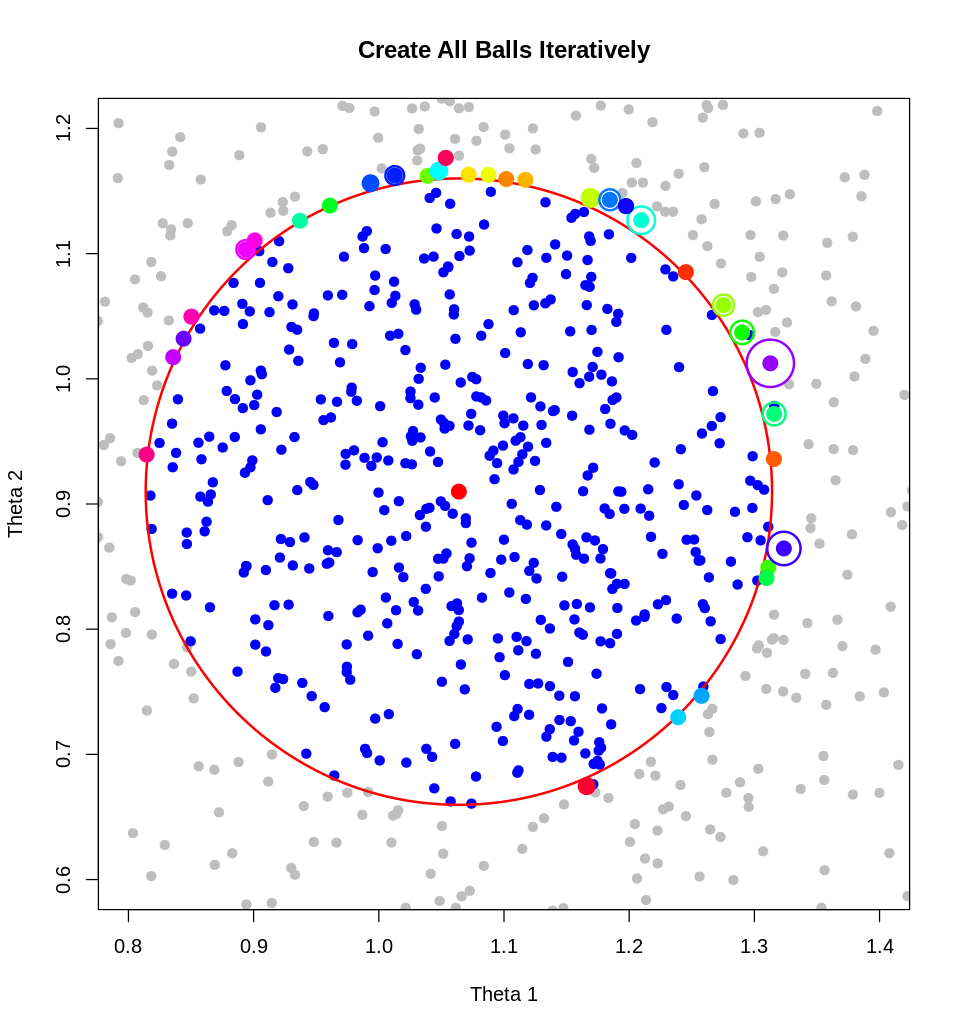

In [ ]:
# Function to find the maximum radius for a new ball centered at `center`
find_ball_radius <- function(center, non_hpd_samples, existing_balls) {
  # Compute Euclidean distances between the center and non-HPD samples
  non_hpd_distances <- sqrt((non_hpd_samples$theta1 - center$theta1)^2 +
                            (non_hpd_samples$theta2 - center$theta2)^2)

  # Find the minimum distance (maximum radius before including non-HPD samples)
  max_radius <- min(non_hpd_distances, na.rm = TRUE)

  # Adjust the radius to avoid overlapping with existing balls
  for (ball in existing_balls) {
    center_distance <- sqrt((center$theta1 - ball$center$theta1)^2 +
                            (center$theta2 - ball$center$theta2)^2)
    if (center_distance < max_radius + ball$radius) {
      max_radius <- min(max_radius, center_distance - ball$radius)
    }
  }

  # Ensure the radius is non-negative
  max_radius <- max(max_radius, 0)
  return(max_radius)
}

# Initialize remaining centers and an empty list to store balls
remaining_centers <- HPD_samples_ball
balls <- list()

# Iteratively find and draw balls
ball_index <- 1
while (nrow(remaining_centers) > 0) {
  # Find the current center (point with the highest density in remaining centers)
  current_center <- remaining_centers[which.max(remaining_centers$log_density), ]

  # Compute the maximum radius for the current center
  max_radius <- find_ball_radius(current_center, Non_HPD_sample_ball, balls)

  # Store the ball's center and radius
  balls[[ball_index]] <- list(
    center = current_center,
    radius = max_radius
  )

  # Update distances from the current center to remaining centers
  remaining_centers$distance <- sqrt((remaining_centers$theta1 - current_center$theta1)^2 +
                                     (remaining_centers$theta2 - current_center$theta2)^2)

  # Filter out centers that are within the new ball's radius
  remaining_centers <- remaining_centers %>% filter(distance > max_radius)

  # Increment the ball index
  ball_index <- ball_index + 1
}

# Plot all samples and the iteratively drawn balls
options(repr.plot.width = 8, repr.plot.height = 8.6)
plot(posterior_samples_ball$theta1, posterior_samples_ball$theta2, col = "grey", pch = 19,
     xlab = "Theta 1", ylab = "Theta 2", main = "Create All Balls Iteratively", xlim = c(0.8, 1.4), ylim = c(0.6, 1.2))
points(HPD_samples_ball$theta1, HPD_samples_ball$theta2, col = "blue", pch = 19)

# Draw each ball with a unique color
for (i in seq_along(balls)) {
  ball <- balls[[i]]
  with(ball$center, {
    symbols(theta1, theta2, circles = ball$radius, add = TRUE, inches = FALSE,
            fg = rainbow(length(balls))[i], lwd = 2)
  })
  points(ball$center$theta1, ball$center$theta2, col = rainbow(length(balls))[i], pch = 19, cex = 1.5, lwd = 2)
}

In [ ]:
# Function to compute the volume (area) of a ball (circle)
compute_volume <- function(radius) {
  return(pi * radius^2)  # Area of a circle = π * r^2
}

# Initialize remaining centers and an empty list to store balls
remaining_centers <- HPD_samples_ball
balls <- list()

# Iteratively find and draw balls
ball_index <- 1
while (nrow(remaining_centers) > 0) {
  # Find the current center (point with the highest density in remaining centers)
  current_center <- remaining_centers[which.max(remaining_centers$log_density), ]

  # Compute the maximum radius for the current center
  max_radius <- find_ball_radius(current_center, Non_HPD_sample_ball, balls)

  # Compute the volume (area) of the ball
  volume <- compute_volume(max_radius)

  # Store the ball's center, radius, and volume
  balls[[ball_index]] <- list(
    center = current_center,
    radius = max_radius,
    volume = volume
  )

  # Update distances from the current center to remaining centers
  remaining_centers$distance <- sqrt((remaining_centers$theta1 - current_center$theta1)^2 +
                                     (remaining_centers$theta2 - current_center$theta2)^2)

  # Filter out centers that are within the new ball's radius
  remaining_centers <- remaining_centers %>% filter(distance > max_radius)

  # Increment the ball index
  ball_index <- ball_index + 1
}

# Print details of each ball
for (i in seq_along(balls)) {
  cat(paste0(
    "Ball ", i, ": Center (", balls[[i]]$center$theta1, ", ", balls[[i]]$center$theta2,
    "), Radius = ", balls[[i]]$radius,
    ", Volume = ", balls[[i]]$volume, "\n"
  ))
}


Ball 1: Center (1.06395445457208, 0.909861646283545), Radius = 0.250180154255819, Volume = 0.196632628454795
Ball 2: Center (1.24531351360164, 1.08522934346846), Radius = 0.0020993286753675, Volume = 1.38455670983325e-05
Ball 3: Center (1.3156192682001, 0.935901761262461), Radius = 0.00282827644668848, Volume = 2.51300635201577e-05
Ball 4: Center (1.10178460543826, 1.15956872451659), Radius = 0.0023762656472216, Volume = 1.77394377971193e-05
Ball 5: Center (1.11709043310846, 1.15894229490696), Radius = 0.00450514515048428, Volume = 6.3762810103903e-05
Ball 6: Center (1.07174830249762, 1.16305137805315), Radius = 0.00312950671085699, Volume = 3.07681686256016e-05
Ball 7: Center (1.08763255795671, 1.1629062938392), Radius = 0.00396989244191254, Volume = 4.95116447349502e-05
Ball 8: Center (1.16924091114134, 1.14449315709461), Radius = 0.00699135233539144, Volume = 0.000153557930806337
Ball 9: Center (1.2753855211793, 1.05886590174672), Radius = 0.00848055801568987, Volume = 0.00022594291

In [ ]:
# Compute the total volume (area) of all balls
total_volume <- sum(sapply(balls, function(ball) ball$volume))

# Print the total volume
cat("Total Volume of All Balls: ", total_volume, "\n")

Total Volume of All Balls:  0.2012637 


In [ ]:
process_sample_est_log <- function(mu_sample) {
  # Compute log-prior density
  log_prior_density <- dmvnorm(mu_sample, mean = rep(0, d), sigma = s0 * diag(d), log = TRUE)

  # Compute log-likelihood for each theta
  log_likelihood <- apply(mu_sample, 1, function(theta) {
    sum(dmvnorm(Y, mean = theta, sigma = diag(d), log = TRUE))
  })

  # Compute log-posterior density (log-prior + log-likelihood)
  log_posterior_density <- log_prior_density + log_likelihood

  # Return a data frame with log-densities
  data.frame(
    theta1 = mu_sample[, 1],
    theta2 = mu_sample[, 2],
    log_density = log_posterior_density
  )
}

# Process samples using log-densities
posterior_samples_est <- process_sample_est_log(sample_est)

is_point_in_balls <- function(point, balls) {
  for (ball in balls) {
    distance <- sqrt((point$theta1 - ball$center$theta1)^2 + (point$theta2 - ball$center$theta2)^2)
    if (distance <= ball$radius) {
      return(TRUE)
    }
  }
  return(FALSE)
}

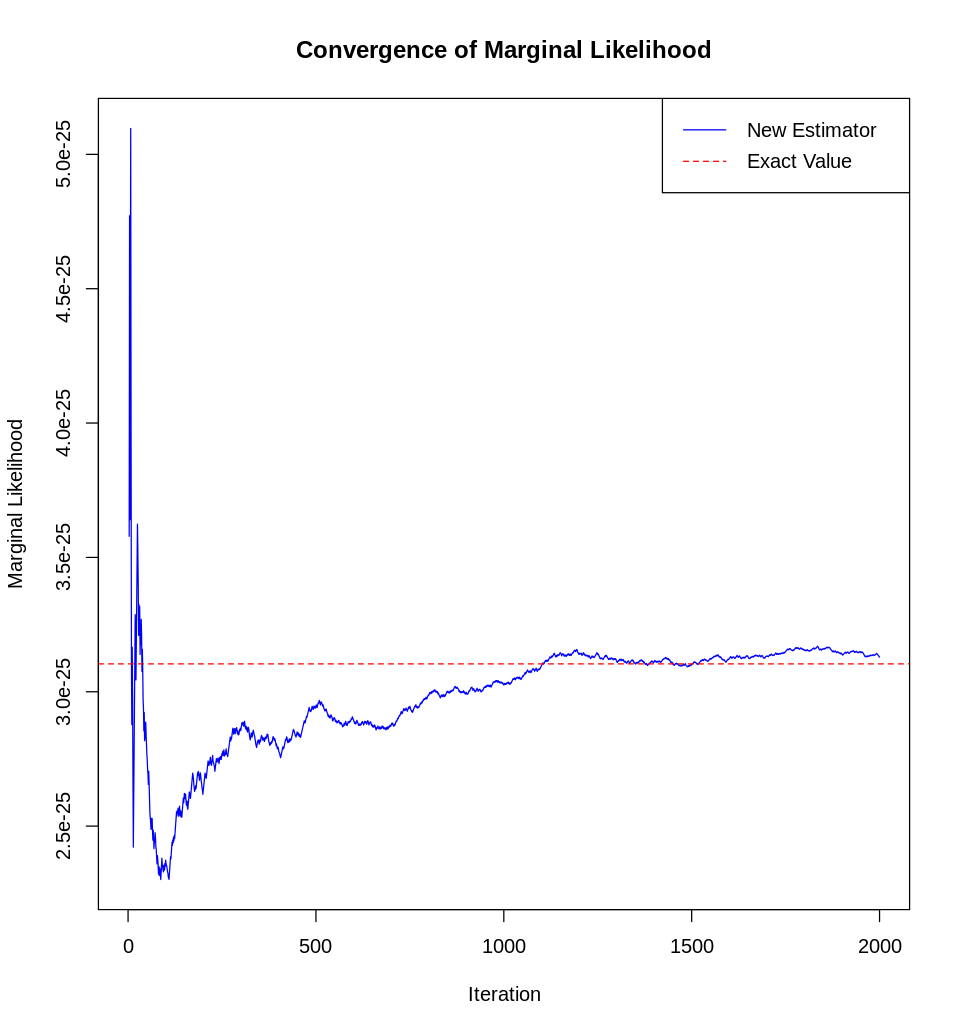

Final Marginal Likelihood: 3.128964e-25 
Final Log Marginal Likelihood: -56.42393 
Exact Marginal Likelihood: 3.103741e-25 
Exact Log Marginal Likelihood: -56.43202 


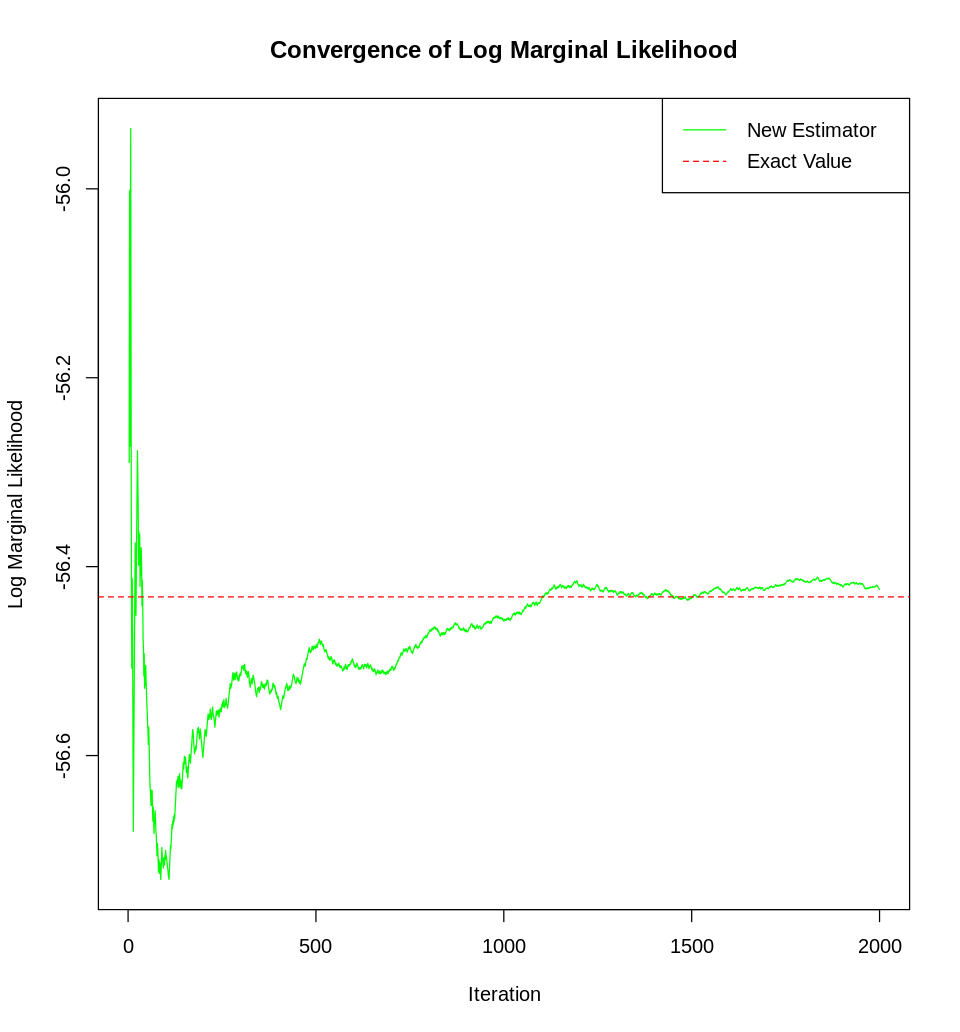

In [ ]:
# Helper function for log-sum-exp
log_sum_exp <- function(log_values) {
  max_log <- max(log_values)
  max_log + log(sum(exp(log_values - max_log)))
}

samples_in_balls <- sapply(1:(mcmc_itr/2), function(it) is_point_in_balls(posterior_samples_est[it, ], balls))
# Compute log-ratios
log_ratio <- log(samples_in_balls) - log(total_volume) - posterior_samples_est$log_density

# Initialize vectors to store results
marginal_likelihood_iter <- numeric(mcmc_itr/2)
log_marginal_likelihood_iter <- numeric(mcmc_itr/2)

# Compute harmonic mean estimator in log-space
for (it in 1:(mcmc_itr/2)) {
  # Log-sum-exp trick to compute the log of the harmonic mean
  log_harmonic_mean_sum <- log_sum_exp(log_ratio[1:it]) - log(it)

  # Log-marginal likelihood is the negative of the log-harmonic mean
  log_marginal_likelihood_iter[it] <- -log_harmonic_mean_sum

  # Marginal likelihood (optional, may cause underflow/overflow)
  marginal_likelihood_iter[it] <- exp(log_marginal_likelihood_iter[it])
}

# Final results
final_marginal_likelihood <- marginal_likelihood_iter[mcmc_itr/2]
final_log_marginal_likelihood <- log_marginal_likelihood_iter[mcmc_itr/2]

# Plot convergence of marginal likelihood
plot(1:(mcmc_itr/2), marginal_likelihood_iter, type = "l", col = "blue",
     xlab = "Iteration", ylab = "Marginal Likelihood",
     main = "Convergence of Marginal Likelihood")
abline(h = exp(log_exact_marginal_likelihood), col = "red", lty = 2)
legend("topright", legend = c("New Estimator", "Exact Value"),
       col = c("blue", "red"), lty = c(1, 2))

# Plot convergence of log-marginal likelihood
plot(1:(mcmc_itr/2), log_marginal_likelihood_iter, type = "l", col = "green",
     xlab = "Iteration", ylab = "Log Marginal Likelihood",
     main = "Convergence of Log Marginal Likelihood")
abline(h = log_exact_marginal_likelihood, col = "red", lty = 2)
legend("topright", legend = c("New Estimator", "Exact Value"),
       col = c("green", "red"), lty = c(1, 2))

# Print final results
cat("Final Marginal Likelihood:", final_marginal_likelihood, "\n")
cat("Final Log Marginal Likelihood:", final_log_marginal_likelihood, "\n")
cat("Exact Marginal Likelihood:", exp(log_exact_marginal_likelihood), "\n")
cat("Exact Log Marginal Likelihood:", log_exact_marginal_likelihood, "\n")


In [ ]:
posterior_samples_cov <- process_sample_log(sample_cov)
HPD_samples_cov <- head(posterior_samples_cov, mcmc_itr/8)
Non_HPD_sample_cov <- tail(posterior_samples_cov, mcmc_itr/8)
n_coverage_hpd <- nrow(HPD_samples_cov)
coverage_test_hpd <- rep(0,n_coverage_hpd)
for(i in 1:n_coverage_hpd){
coverage_test_hpd[i] <-is_point_in_balls(HPD_samples_cov[i,], balls)
  }
hpd_coverage<- sum(coverage_test_hpd)/ n_coverage_hpd
cat("Number of HPD coverage sample in ball:", sum(coverage_test_hpd), "\n")
cat("All HPD samples", n_coverage_hpd, "\n")
cat("HPD Coverage:", hpd_coverage,"\n")

n_coverage_nhpd <- nrow(Non_HPD_sample_cov)
coverage_test_nhpd <- rep(0,n_coverage_nhpd)
for(i in 1:n_coverage_nhpd){
coverage_test_hpd[i] <-is_point_in_balls(Non_HPD_sample_cov[i,], balls)
  }
nhpd_coverage<- sum(coverage_test_nhpd)/ n_coverage_nhpd
cat("Number of Non HPD coverage sample in ball:", sum(coverage_test_nhpd), "\n")
cat("All Non HPD samples", n_coverage_nhpd, "\n")
cat("Non Coverage:", nhpd_coverage)

Number of HPD coverage sample in ball: 489 
All HPD samples 500 
HPD Coverage: 0.978 
Number of Non HPD coverage sample in ball: 0 
All Non HPD samples 500 
Non Coverage: 0

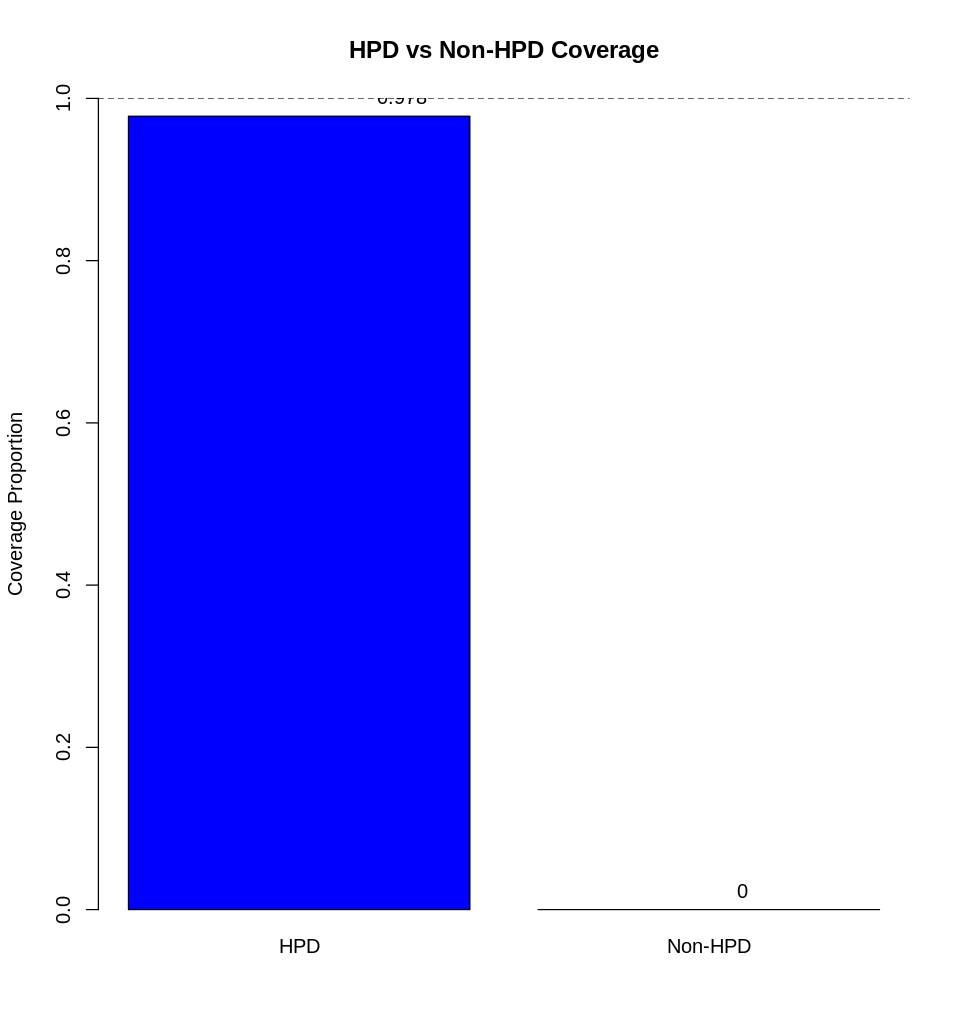

In [ ]:

# Coverage Bar Plot
coverage_data <- data.frame(
  Category = c("HPD", "Non-HPD"),
  Coverage = c(hpd_coverage, nhpd_coverage)
)

barplot(coverage_data$Coverage, names.arg = coverage_data$Category, col = c("blue", "red"),
        ylim = c(0, 1), main = "HPD vs Non-HPD Coverage",
        ylab = "Coverage Proportion")

abline(h = 1, col = "black", lty = 2)
text(1, hpd_coverage, labels = round(hpd_coverage, 4), pos = 3)
text(2, nhpd_coverage, labels = round(nhpd_coverage, 4), pos = 3)


In [ ]:
mvg_log_post <- function(param, X, sig2){
  n <- nrow(X)
  d <- length(param)
  l <- sum(dmvnorm(X, param, diag(d),log = TRUE))
  p <- dmvnorm(param, rep(0,d), (sig2)*diag(d), log = TRUE)
  return(p + l)
}
log_post <- apply(sample_posterior, 1,mvg_log_post,Y,s0)

In [ ]:
thames_correction <- function(lps = NULL,params,n_samples = NULL,d = NULL, radius = NULL,
                   p = 0.025, q = 1-p, lp_func = NULL,
                   bound = NULL, n_simuls = 1e5){

  # dimension of parameter space
  if(is.null(d)){
    d <- dim(params)[2]
    if(is.null(d)){
      d <- 1
    }
  }

  # radius of A
  if(is.null(radius)){
    radius <- sqrt(d+1)
  }

  # number of posterior samples
  if(is.null(n_samples)){
    if(d==1){
      n_samples <- length(params)
    }else{
      n_samples <- dim(params)[1]
    }
  }

  # calculate unnormalized log posterior values
  if(is.null(lps)){
    lps <- lp_func(params)
  }

  if(length(lps) != n_samples){
    return('Error: number of unnormalized log posterior values does not match posterior sample size.')
  }

  # split the sample
  n1 <- n_samples %/% 2
  n2 <- n_samples - n1
  if(d==1){
    params1 <- params[1:n1]
    params2 <- params[(n1+1):n_samples]
  }else{
    params1 <- params[1:n1,]
    params2 <- params[(n1+1):n_samples,]
  }
  lps1 <- lps[1:n1]
  lps2 <- lps[(n1+1):n_samples]

  # calculate posterior mode and covariance from first half of sample
  if(d==1){
    theta_hat <- mean(params1)
    sigma_hat <- var(params1)
    sigma_svd = sigma_hat # one-dimensional svd is just the variance

    log_det_sigma_hat <- log(sigma_hat)

    # which samples are in A?
    inA <- sapply(params2,function(theta){
      # calculate distance from theta_hat
      theta_tilde <- (theta-theta_hat)/sqrt(sigma_hat)

      # is distance of theta less than the radius?
      return(sum(theta_tilde^2) < radius^2)
    })
  }else{
    theta_hat <- colMeans(params1)
    sigma_hat <- cov(params1)

    # calculate SVD of sigma_hat
    sigma_svd = svd(sigma_hat)

    # calculate log(det(sigma_hat))
    log_det_sigma_hat = sum(log(sigma_svd$d))

    # which samples are in A?
    inA <- apply(params2,1,function(theta){
      # calculate distance from theta_hat
      theta_tilde <-  sigma_svd$d^(-1/2) * (t(sigma_svd$v) %*% (theta-theta_hat))

      # is distance of theta less than the radius?
      return(sum(theta_tilde^2) < radius^2)
    })
  }

  # log volume of A
  logvolA = d*log(radius)+(d/2)*log(pi)+log_det_sigma_hat/2-lgamma(d/2+1)

  # calculate log(zhat_inv)
  log_zhat_inv_values <- numeric(length(lps2))
  for (i in seq_along(lps2)) {
    log_zhat_inv_values[i] <- log(mean(exp(-(lps2[1:i] - max(lps2[1:i]))) * inA[1:i])) - logvolA - max(lps2[1:i])
  }

  log_zhat_inv  = log_zhat_inv_values[length(lps2)]


  return(list(log_zhat_inv = -log_zhat_inv,
              log_zhat_inv_values = -log_zhat_inv_values,
              zhat_inv = exp(-log_zhat_inv),
              zhat_inv_values= exp(-log_zhat_inv_values)
  ))
}

In [ ]:
result_thames <- thames_correction(log_post,sample_posterior)

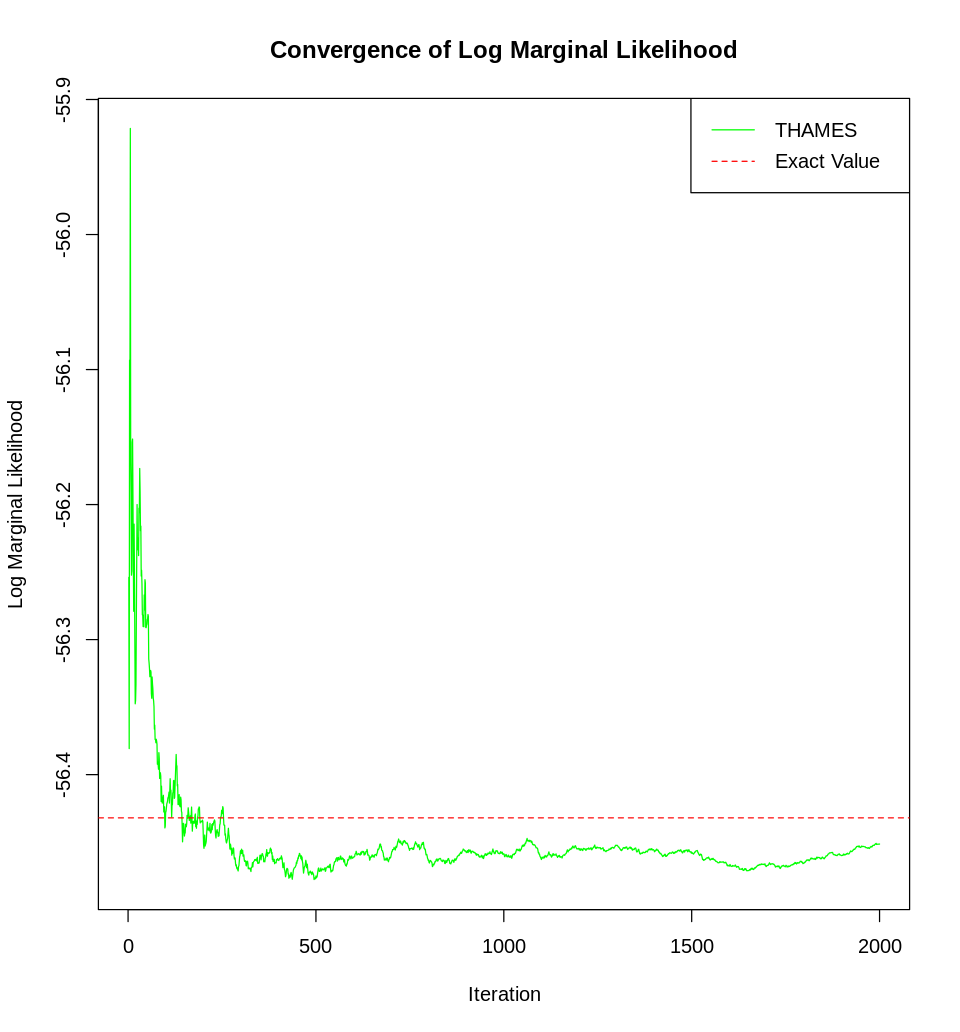

THAMES Log Marginal Likelihood: -56.45139 
Exact Log Marginal Likelihood: -56.43202 
THAMES Marginal Likelihood: 3.044202e-25 
Exact Marginal Likelihood: 3.103741e-25 


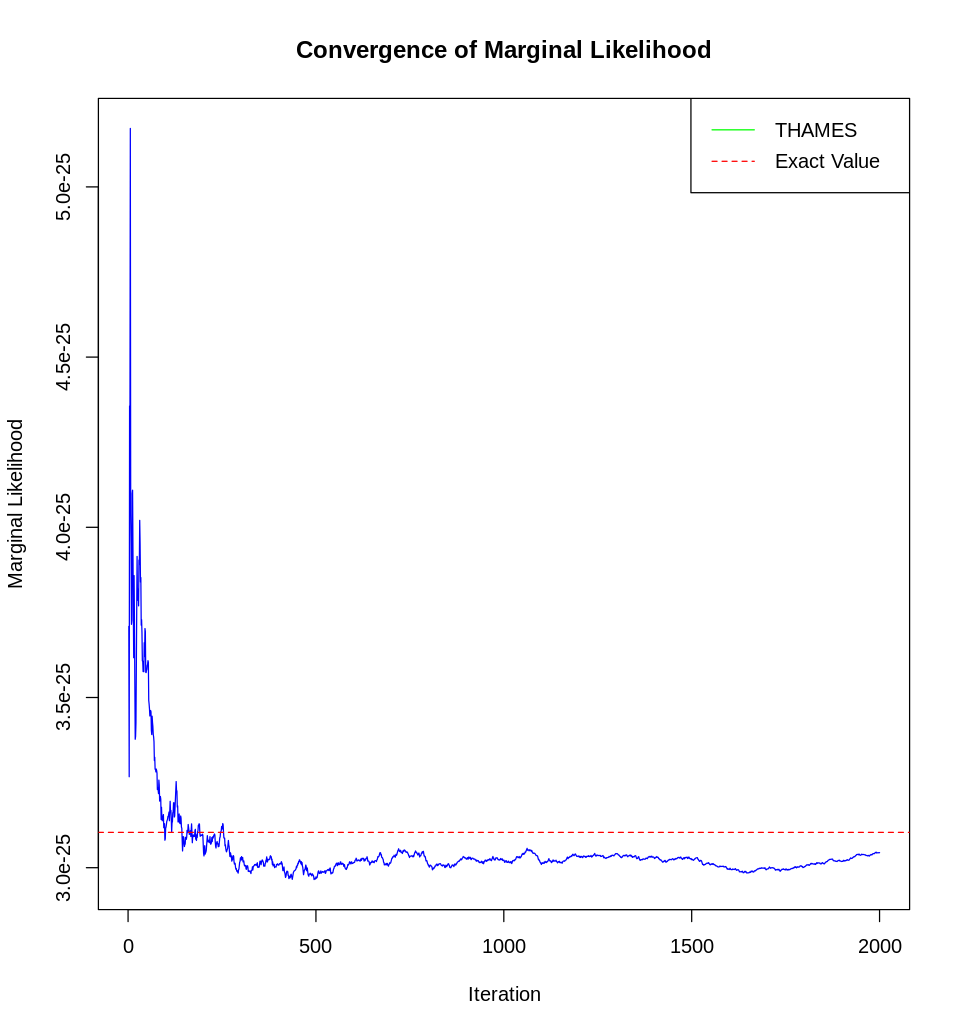

In [ ]:
plot(1:(mcmc_itr/2), result_thames$log_zhat_inv_values, type = "l", col = "green",
     xlab = "Iteration", ylab = "Log Marginal Likelihood",
     main = "Convergence of Log Marginal Likelihood")
abline(h = log_exact_marginal_likelihood, col = "red", lty = 2)
legend("topright", legend = c("THAMES", "Exact Value"),
       col = c("green", "red"), lty = c(1, 2))

plot(1:(mcmc_itr/2), result_thames$zhat_inv_values, type = "l", col = "blue",
     xlab = "Iteration", ylab = "Marginal Likelihood",
     main = "Convergence of Marginal Likelihood")
abline(h = exp(log_exact_marginal_likelihood), col = "red", lty = 2)
legend("topright", legend = c("THAMES", "Exact Value"),
       col = c("green", "red"), lty = c(1, 2))

cat("THAMES Log Marginal Likelihood:", result_thames$log_zhat_inv, "\n")
cat("Exact Log Marginal Likelihood:", log_exact_marginal_likelihood, "\n")
cat("THAMES Marginal Likelihood:", result_thames$zhat_inv, "\n")
cat("Exact Marginal Likelihood:", exp(log_exact_marginal_likelihood), "\n")

In [ ]:
length(result_thames$log_zhat_inv_values)
length(log_marginal_likelihood_iter)

[1] 2000

[1] 2000

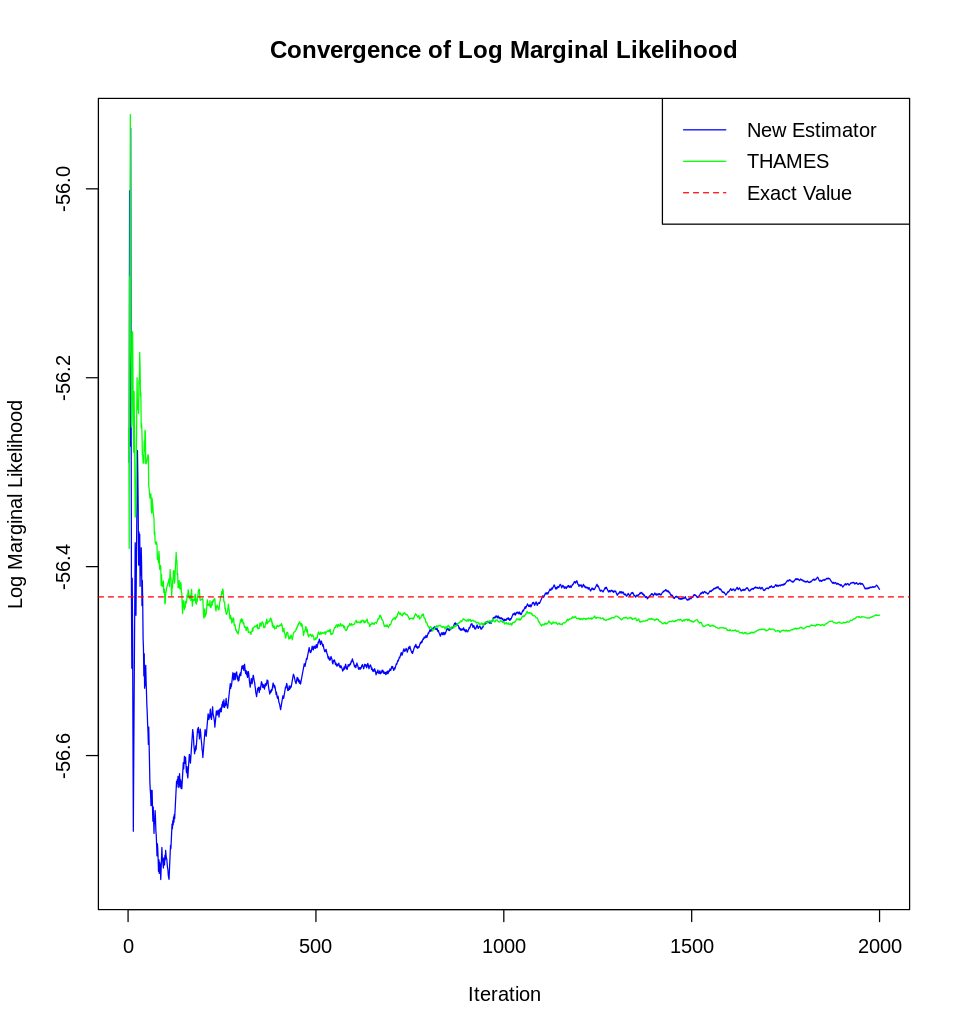

In [ ]:
plot(1:(mcmc_itr/2), log_marginal_likelihood_iter, type = "l", col = "blue",
     xlab = "Iteration", ylab = "Log Marginal Likelihood",
     main = "Convergence of Log Marginal Likelihood")

lines(1:(mcmc_itr/2), result_thames$log_zhat_inv_values, col = "green")  # Add THAMES estimator

abline(h = log_exact_marginal_likelihood, col = "red", lty = 2)  # Exact value as a horizontal line

legend("topright", legend = c("New Estimator", "THAMES", "Exact Value"),
       col = c("blue", "green", "red"), lty = c(1, 1, 2))  # Corrected lty vector


In [ ]:
cat("Final Log Marginal Likelihood:", final_log_marginal_likelihood, "\n")
cat("THAMES Log Marginal Likelihood:", result_thames$log_zhat_inv, "\n")
cat("Exact Log Marginal Likelihood:", log_exact_marginal_likelihood, "\n")
cat("Final Marginal Likelihood:", final_marginal_likelihood, "\n")
cat("THAMES Marginal Likelihood:", result_thames$zhat_inv, "\n")
cat("Exact Marginal Likelihood:", exp(log_exact_marginal_likelihood), "\n")


Final Log Marginal Likelihood: -56.42393 
THAMES Log Marginal Likelihood: -56.45139 
Exact Log Marginal Likelihood: -56.43202 
Final Marginal Likelihood: 3.128964e-25 
THAMES Marginal Likelihood: 3.044202e-25 
Exact Marginal Likelihood: 3.103741e-25 


In [ ]:
set.seed(123)
s0 <- 1
n <- 20
d <- 2
mu_star <- rep(1, d)
mcmc_itr <- 4000

Y <- rmvnorm(n, mu_star, sigma = diag(d))
sn <- 1 / (n + 1/s0)
#mn <- colMeans(Y) * n / (n + 1/s0)
mn = apply(Y,2,sum)/(n + 1/s0)
z_estimate_new <- rep(0,100)
z_estimate_thames <- rep(0,100)
for(m in 1:100){
sample_posterior <- rmvnorm(mcmc_itr, mn, sigma = sn * diag(d))
sample_ball <- sample_posterior[1:(mcmc_itr/4),]
sample_cov <- sample_posterior[(mcmc_itr/4+1):(mcmc_itr/2),]
sample_est <- sample_posterior[(mcmc_itr/2+1):mcmc_itr,]

process_sample <- function(mu_sample) {
  prior_density <- dmvnorm(mu_sample, mean = rep(0, d), sigma = s0 * diag(d))
  likelihood <- apply(mu_sample, 1, function(theta) prod(dmvnorm(Y, mean = theta, sigma = diag(d))))
  posterior_densities_ball <- prior_density * likelihood
  maxim <- max(posterior_densities_ball)
  posterior_densities_ball_scaled<- posterior_densities_ball/maxim
  data.frame(
    theta1 = mu_sample[, 1],
    theta2 = mu_sample[, 2],
    density = posterior_densities_ball_scaled
  ) %>% arrange(desc(density))
}

posterior_samples_ball <- process_sample(sample_ball)
HPD_samples_ball <- head(posterior_samples_ball, mcmc_itr/8)
Non_HPD_sample_ball <- tail(posterior_samples_ball, mcmc_itr/8)

first_center <- HPD_samples_ball[which.max(HPD_samples_ball$density), ]
find_max_radius <- function(center, non_hpd_samples) {
 non_hpd_distances <- sqrt((non_hpd_samples$theta1 - center$theta1)^2 +
                            (non_hpd_samples$theta2 - center$theta2)^2)

  max_radius <- min(non_hpd_distances, na.rm = TRUE)

  return(max_radius)
}
max_radius <- find_max_radius(first_center, Non_HPD_sample_ball)

HPD_samples_ball$distance <- sqrt((HPD_samples_ball$theta1 - first_center$theta1)^2 +
                           (HPD_samples_ball$theta2 - first_center$theta2)^2)

find_ball_radius <- function(center, non_hpd_samples, existing_balls) {
  non_hpd_distances <- sqrt((non_hpd_samples$theta1 - center$theta1)^2 +
                            (non_hpd_samples$theta2 - center$theta2)^2)
  max_radius <- min(non_hpd_distances, na.rm = TRUE)

  for (ball in existing_balls) {
    center_distance <- sqrt((center$theta1 - ball$center$theta1)^2 +
                            (center$theta2 - ball$center$theta2)^2)
    if (center_distance < max_radius + ball$radius) {
      max_radius <- min(max_radius, center_distance - ball$radius)
    }
  }

  max_radius <- max(max_radius, 0)
  return(max_radius)
}

remaining_centers <- HPD_samples_ball

balls <- list()

ball_index <- 1
while (nrow(remaining_centers) > 0) {
  current_center <- remaining_centers[which.max(remaining_centers$density), ]

  max_radius <- find_ball_radius(current_center, Non_HPD_sample_ball, balls)

  balls[[ball_index]] <- list(
    center = current_center,
    radius = max_radius
  )
  remaining_centers$distance <- sqrt((remaining_centers$theta1 - current_center$theta1)^2 +
                                     (remaining_centers$theta2 - current_center$theta2)^2)
  remaining_centers <- remaining_centers %>% filter(distance > max_radius)
  ball_index <- ball_index + 1
}
compute_volume <- function(radius) {
  return(pi * radius^2)
    #return(pi * radius^2 *(1/(n+1)))

}

remaining_centers <- HPD_samples_ball
balls <- list()

ball_index <- 1
while (nrow(remaining_centers) > 0) {
  current_center <- remaining_centers[which.max(remaining_centers$density), ]

  max_radius <- find_ball_radius(current_center, Non_HPD_sample_ball, balls)

  volume <- compute_volume(max_radius)

  balls[[ball_index]] <- list(
    center = current_center,
    radius = max_radius,
    volume = volume
  )

  remaining_centers$distance <- sqrt((remaining_centers$theta1 - current_center$theta1)^2 +
                                     (remaining_centers$theta2 - current_center$theta2)^2)
  remaining_centers <- remaining_centers %>% filter(distance > max_radius)

  ball_index <- ball_index + 1
}

#for (i in seq_along(balls)) {
  #cat(paste0(
    #"Ball ", i, ": Center (", balls[[i]]$center$theta1, ", ", balls[[i]]$center$theta2,
    #"), Radius = ", balls[[i]]$radius,
    #", Volume = ", balls[[i]]$volume, "\n"
  #))
#}
total_volume <- sum(sapply(balls, function(ball) ball$volume))

#cat("Total Volume of All Balls: ", total_volume, "\n")

process_sample_est <- function(mu_sample) {
  prior_density <- dmvnorm(mu_sample, mean = rep(0, d), sigma = s0 * diag(d))
  likelihood <- apply(mu_sample, 1, function(theta) prod(dmvnorm(Y, mean = theta, sigma = diag(d))))
  posterior_densities_ball <- prior_density * likelihood
  maxim <- max(posterior_densities_ball)
  posterior_densities_ball_scaled<- posterior_densities_ball/maxim
  df <- data.frame(
    theta1 = mu_sample[, 1],
    theta2 = mu_sample[, 2],
    density = posterior_densities_ball_scaled
  )
  list(df, maxim)
}
posterior_samples_est <- process_sample_est(sample_est)
maxim<- as.numeric(posterior_samples_est[2])
posterior_samples_est <- as.data.frame(posterior_samples_est[1])
# Indicator function for points in balls
is_point_in_balls <- function(point, balls) {
  for (ball in balls) {
    distance <- sqrt((point$theta1 - ball$center$theta1)^2 + (point$theta2 - ball$center$theta2)^2)
    if (distance <= ball$radius) {
      return(TRUE)
    }
  }
  return(FALSE)
}
samples_in_balls <- sapply(1:(mcmc_itr/2), function(it) is_point_in_balls(posterior_samples_est[it, ], balls))
ratio <- samples_in_balls / (posterior_samples_est$density * total_volume)

marginal_likelihood_iter <- numeric(mcmc_itr/2)
log_marginal_likelihood_iter <- numeric(mcmc_itr/2)

for (it in 1:(mcmc_itr/2)) {
  harmonic_mean_sum <- sum(ratio[1:it]) / it
  marginal_likelihood_iter[it] <- (1 / harmonic_mean_sum)*maxim
  log_marginal_likelihood_iter[it] <- log(marginal_likelihood_iter[it])
}

final_marginal_likelihood <- marginal_likelihood_iter[mcmc_itr/2]
z_estimate_new[m]=final_marginal_likelihood

log_post <- apply(sample_posterior, 1,mvg_log_post,Y,s0)
result <- thames(log_post,sample_posterior)
z_estimate_thames[m] <- exp(-result$log_zhat_inv)

}

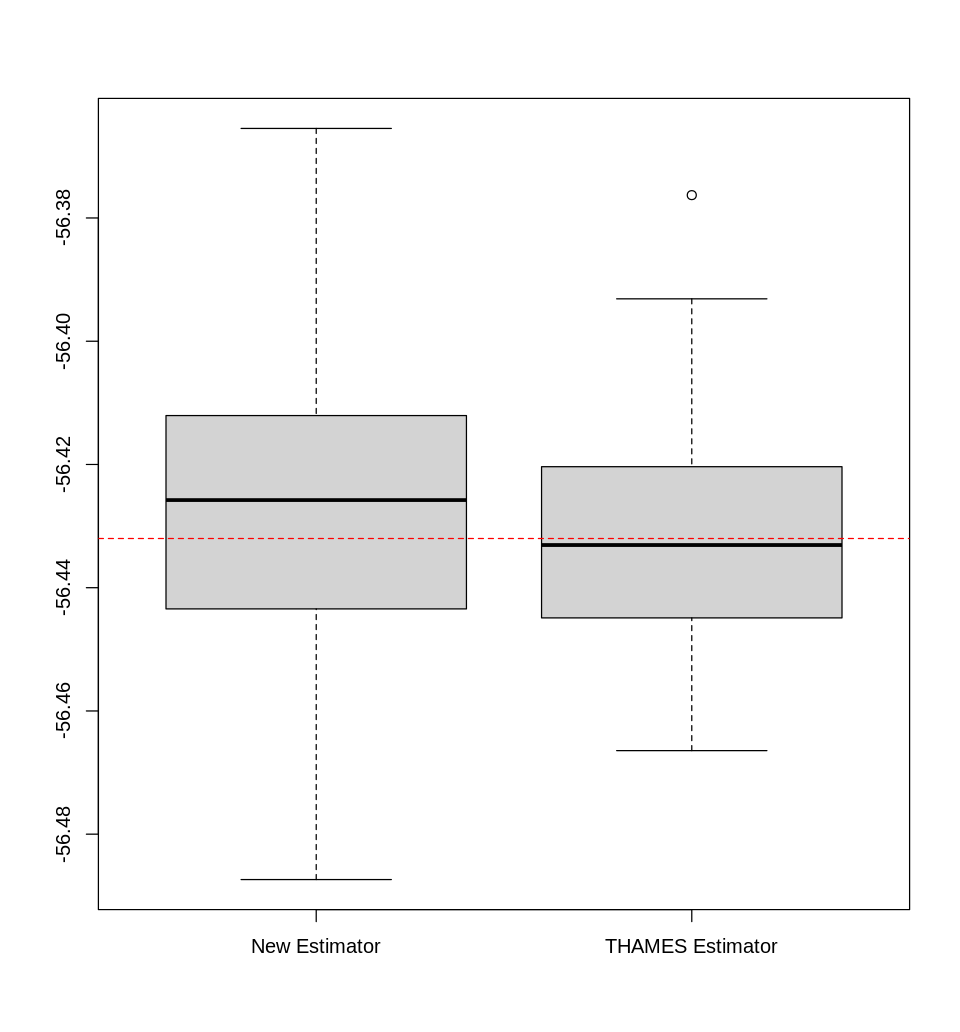

In [ ]:
boxplot(log(z_estimate_new), log(z_estimate_thames),
        names = c("New Estimator", "THAMES Estimator"))
abline(h=log_exact_marginal_likelihood, col = "red", lty = 2)
# abline(v = 2.5, col = "red", lwd = 2, lty = 2)


In [ ]:
boxplot(z_estimate_new, z_estimate_thames,
        names = c("New Estimate", "Thames Estimate"))
abline(h=exp(log_exact_marginal_likelihood), col = "red", lty = 2)
# abline(v = 2.5, col = "red", lwd = 2, lty = 2)


In [ ]:
thames <- function(lps = NULL,params,n_samples = NULL,d = NULL, radius = NULL,
                   p = 0.025, q = 1-p, lp_func = NULL,
                   bound = NULL, n_simuls = 1e5){

  # dimension of parameter space
  if(is.null(d)){
    d <- dim(params)[2]
    if(is.null(d)){
      d <- 1
    }
  }

  # radius of A
  if(is.null(radius)){
    radius <- sqrt(d+1)
  }

  # number of posterior samples
  if(is.null(n_samples)){
    if(d==1){
      n_samples <- length(params)
    }else{
      n_samples <- dim(params)[1]
    }
  }

  # calculate unnormalized log posterior values
  if(is.null(lps)){
    lps <- lp_func(params)
  }

  if(length(lps) != n_samples){
    return('Error: number of unnormalized log posterior values does not match posterior sample size.')
  }

  # split the sample
  n1 <- n_samples %/% 2
  n2 <- n_samples - n1
  if(d==1){
    params1 <- params[1:n1]
    params2 <- params[(n1+1):n_samples]
  }else{
    params1 <- params[1:n1,]
    params2 <- params[(n1+1):n_samples,]
  }
  lps1 <- lps[1:n1]
  lps2 <- lps[(n1+1):n_samples]

  # calculate posterior mode and covariance from first half of sample
  if(d==1){
    theta_hat <- mean(params1)
    sigma_hat <- var(params1)
    sigma_svd = sigma_hat # one-dimensional svd is just the variance

    log_det_sigma_hat <- log(sigma_hat)

    # which samples are in A?
    inA <- sapply(params2,function(theta){
      # calculate distance from theta_hat
      theta_tilde <- (theta-theta_hat)/sqrt(sigma_hat)

      # is distance of theta less than the radius?
      return(sum(theta_tilde^2) < radius^2)
    })
  }else{
    theta_hat <- colMeans(params1)
    sigma_hat <- cov(params1)

    # calculate SVD of sigma_hat
    sigma_svd = svd(sigma_hat)

    # calculate log(det(sigma_hat))
    log_det_sigma_hat = sum(log(sigma_svd$d))

    # which samples are in A?
    inA <- apply(params2,1,function(theta){
      # calculate distance from theta_hat
      theta_tilde <-  sigma_svd$d^(-1/2) * (t(sigma_svd$v) %*% (theta-theta_hat))

      # is distance of theta less than the radius?
      return(sum(theta_tilde^2) < radius^2)
    })
  }

  # log volume of A
  logvolA = d*log(radius)+(d/2)*log(pi)+log_det_sigma_hat/2-lgamma(d/2+1)

  # calculate log(zhat_inv)
  log_zhat_inv  = log(mean(exp(-(lps2-max(lps2)))*inA))-logvolA-max(lps2)

  return(list(log_zhat_inv = log_zhat_inv))
}

In [ ]:
set.seed(123)
s0 <- 1
n <- 20
d <- 2
mu_star <- rep(1, d)
mcmc_itr <- 2000

Y <- rmvnorm(n, mu_star, sigma = diag(d))
sn <- 1 / (n + 1/s0)
mn <- colMeans(Y) * n / (n + 1/s0)
log_z_estimate <- rep(0, 100)
log_z_estimate_thames <- rep(0, 100)

log_sum_exp <- function(log_values) {
  max_log <- max(log_values)
  max_log + log(sum(exp(log_values - max_log)))
}

for(m in 1:100) {
  sample_ball <- rmvnorm(mcmc_itr, mn, sigma = sn * diag(d))
  sample_est <- rmvnorm(mcmc_itr, mn, sigma = sn * diag(d))

  process_sample_log <- function(mu_sample) {
    log_prior <- dmvnorm(mu_sample, rep(0, d), s0*diag(d), log=TRUE)
    log_likelihood <- apply(mu_sample, 1, function(theta) {
      sum(dmvnorm(Y, theta, diag(d), log=TRUE))
    })
    log_posterior <- log_prior + log_likelihood

    list(
      df = data.frame(
        theta1 = mu_sample[,1],
        theta2 = mu_sample[,2],
        log_density = log_posterior
      ))
  }

  processed <- process_sample_log(sample_ball)
  posterior_samples_ball <- processed$df %>% arrange(desc(log_density))

  HPD_samples_ball <- head(posterior_samples_ball, mcmc_itr/2)
  Non_HPD_sample_ball <- tail(posterior_samples_ball, mcmc_itr/2)

first_center <- HPD_samples_ball[which.max(HPD_samples_ball$log_density), ]
find_max_radius <- function(center, non_hpd_samples) {
 non_hpd_distances <- sqrt((non_hpd_samples$theta1 - center$theta1)^2 +
                            (non_hpd_samples$theta2 - center$theta2)^2)

  max_radius <- min(non_hpd_distances, na.rm = TRUE)

  return(max_radius)
}
max_radius <- find_max_radius(first_center, Non_HPD_sample_ball)

HPD_samples_ball$distance <- sqrt((HPD_samples_ball$theta1 - first_center$theta1)^2 +
                           (HPD_samples_ball$theta2 - first_center$theta2)^2)

find_ball_radius <- function(center, non_hpd_samples, existing_balls) {
  non_hpd_distances <- sqrt((non_hpd_samples$theta1 - center$theta1)^2 +
                            (non_hpd_samples$theta2 - center$theta2)^2)
  max_radius <- min(non_hpd_distances, na.rm = TRUE)

  for (ball in existing_balls) {
    center_distance <- sqrt((center$theta1 - ball$center$theta1)^2 +
                            (center$theta2 - ball$center$theta2)^2)
    if (center_distance < max_radius + ball$radius) {
      max_radius <- min(max_radius, center_distance - ball$radius)
    }
  }

  max_radius <- max(max_radius, 0)
  return(max_radius)
}


 # Modified ratio calculation using log-space
  compute_volume <- function(radius) {
    return(pi * radius^2)  # Keep original volume calculation
  }

remaining_centers <- HPD_samples_ball

balls <- list()

ball_index <- 1
while (nrow(remaining_centers) > 0) {
  current_center <- remaining_centers[which.max(remaining_centers$log_density), ]

  max_radius <- find_ball_radius(current_center, Non_HPD_sample_ball, balls)
  volume <- compute_volume(max_radius)

  balls[[ball_index]] <- list(
    center = current_center,
    radius = max_radius,
    volume = volume
  )
  remaining_centers$distance <- sqrt((remaining_centers$theta1 - current_center$theta1)^2 +
                                     (remaining_centers$theta2 - current_center$theta2)^2)
  remaining_centers <- remaining_centers %>% filter(distance > max_radius)
  ball_index <- ball_index + 1
}

 total_volume <- sum(sapply(balls, function(ball) ball$volume))


  # Process estimation samples
  process_sample_est_log <- function(mu_sample) {
    log_prior <- dmvnorm(mu_sample, rep(0, d), s0*diag(d), log=TRUE)
    log_likelihood <- apply(mu_sample, 1, function(theta) {
      sum(dmvnorm(Y, theta, diag(d), log=TRUE))
    })
    log_posterior <- log_prior + log_likelihood
    data.frame(
      theta1 = mu_sample[,1],
      theta2 = mu_sample[,2],
      log_density = log_posterior
    )
  }

  posterior_samples_est <- process_sample_est_log(sample_est)

  # Indicator function for points in balls
is_point_in_balls <- function(point, balls) {
  for (ball in balls) {
    distance <- sqrt((point$theta1 - ball$center$theta1)^2 + (point$theta2 - ball$center$theta2)^2)
    if (distance <= ball$radius) {
      return(TRUE)
    }
  }
  return(FALSE)
}
  samples_in_balls <- sapply(1:mcmc_itr, function(it) is_point_in_balls(posterior_samples_est[it, ], balls))
  eps = 1e-10
  # Calculate log-ratios
  # log_ratio <- log(samples_in_balls + eps) - log(total_volume) - posterior_samples_est$log_density
  log_samples_in_balls <- ifelse(samples_in_balls > 0, log(samples_in_balls), -Inf)  # Ensure stability
  log_ratio <- log_samples_in_balls - log(total_volume) - posterior_samples_est$log_density


log_marginal_likelihood_iter <- numeric(mcmc_itr)

  for (it in 1:mcmc_itr) {
  # Log-sum-exp trick to compute the log of the harmonic mean
  log_harmonic_mean_sum <- log_sum_exp(log_ratio[1:it]) - log(it)

  # Log-marginal likelihood is the negative of the log-harmonic mean
  log_marginal_likelihood_iter[it] <- -log_harmonic_mean_sum

  # Marginal likelihood (optional, may cause underflow/overflow)
  # marginal_likelihood_iter[it] <- exp(log_marginal_likelihood_iter[it])
}

  log_z_estimate[m] <- log_marginal_likelihood_iter[mcmc_itr]

  # Compute marginal likelihood using log-space
  # log_z_estimate <- numeric(mcmc_itr)
  # for(it in 1:mcmc_itr) {
  #   if(it == 1) {
  #     current_log_sum <- log_ratio[1]
  #   } else {
  #     current_log_sum <- log_sum_exp(log_ratio[1:it])
  #   }
  #   log_z_estimate[it] <- -current_log_sum + log(it)
  # }
  # log_z_estimate[m] <- -log_sum_exp(log_ratio[1:mcmc_itr]) + log(mcmc_itr)

  # z_estimate_new[m] <- exp(log_z_estimate[mcmc_itr])

  # THAMES estimator
  log_post <- apply(sample_est, 1, function(theta) {
    dmvnorm(theta, rep(0, d), s0*diag(d), log=TRUE) +
      sum(dmvnorm(Y, theta, diag(d), log=TRUE))
  })
  result <- thames(log_post, sample_est)
  log_z_estimate_thames[m] <- -result$log_zhat_inv
}

# Analysis of results
cat("New Method Mean:", mean(log_z_estimate), "SD:", sd(log_z_estimate), "\n")
cat("THAMES Mean:", mean(log_z_estimate_thames), "SD:", sd(log_z_estimate_thames), "\n")

In [ ]:

# Analysis of results
cat("New Method Mean:", mean(log_z_estimate), "SD:", sd(log_z_estimate), "\n")
cat("THAMES Mean:", mean(log_z_estimate_thames), "SD:", sd(log_z_estimate_thames), "\n")

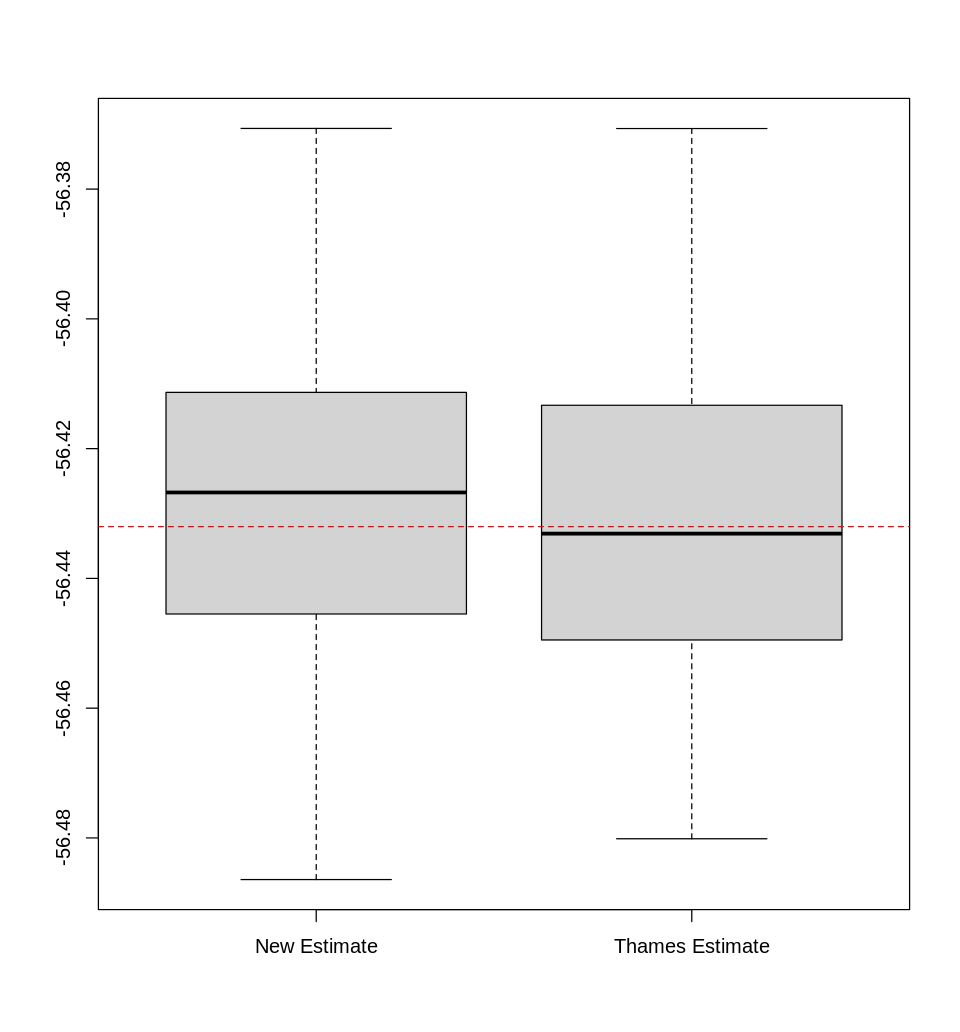

In [ ]:
boxplot(log_z_estimate, log_z_estimate_thames,
        names = c("New Estimate", "Thames Estimate"))
abline(h=log_exact_marginal_likelihood, col = "red", lty = 2)
# abline(v = 2.5, col = "red", lwd = 2, lty = 2)


In [ ]:
eps

ERROR: Error: object 'eps' not found
